# Graph Coloring using Genetic Algorithms

**Author:** Adrian Mateos Garza  
**GitHub:** [@AdrianMateosG](https://github.com/AdrianMateosG)

## Overview
This project implements a genetic algorithm to solve the Graph Coloring Problem (GCP), which is a well-known NP-hard problem in computer science and mathematics. The goal is to assign colors to vertices of a graph such that no adjacent vertices share the same color, while using the minimum number of colors possible.

## How it Works

### The Algorithm
The implementation uses a genetic algorithm with the following components:
1. **Population Initialization**: Random valid color assignments for each vertex
2. **Fitness Function**: Evaluates solutions based on the number of correctly colored vertices (no adjacent vertices sharing the same color)
3. **Selection**: Roulette wheel selection method to choose parent chromosomes based on fitness
4. **Crossover**: Single-point crossover with configurable probability
5. **Mutation**: Random color reassignment with low probability to maintain diversity
6. **Stop criterion**: Algorithm stops once it has found a feasible solution given the number of colors

### Input
- Graph structure in a spreadsheet format (adjacency matrix), such as CSV, XLSX, or any format accepted by pandas.
- Configurable parameters:
  - Population size
  - Number of colors
  - Mutation rate
  - Crossover rate
  - Maximum iterations

### Output
- List of feasible solutions found
- Best solution with its fitness value
- Visualization of colored graph (optional)
- Computation time

### Solution Representation
In this implementation, solutions are represented as lists where each index corresponds to a vertex in the graph, and the value at that index represents the color assigned to that vertex. For example, in a solution `[1, 2, 3, 1]`, vertex 0 is colored red, vertex 1 is green, vertex 2 is blue, and vertex 3 is red.

The available colors are (maximum 8):
1. Red
2. Green
3. Blue
4. Purple
5. Cyan
6. Yellow
7. White
8. Gray

A solution is considered valid (feasible) when no adjacent vertices share the same color.


## Default Parameters
| Parameter | Value | Description |
|-----------|--------|-------------|
| Population Size | 50 | Number of individuals in each generation |
| Number of Colors | 4 | Maximum colors available for vertex coloring |
| Crossover Probability | 0.95 | Probability of performing crossover between parents |
| Mutation Probability | 0.05 | Probability of random color mutation |
| Maximum Iterations | 100,000 | Maximum number of generations |

## Requirements
- Python 3.7+
- pandas
- numpy
- networkx
- matplotlib

## Visualization of Example Graph
Here's a visualization of the graph we're gonna work with in this notebook, the adjacency matrix is under the file name "*example_graph.csv*"

![Initial Graph](InitialGraph.png)

In [23]:
import pandas as pd
import numpy as np
import random
import itertools
import time
import networkx as nx
import matplotlib.pyplot as plt

In [61]:
def create_population(population_size, chromosome_length, num_colors):
    #Creates population of certain size, length, with numbers varying from 1 to num_colors
    population = []
    for _ in range(population_size):
        individual = [random.randint(1, num_colors) for _ in range(chromosome_length)]
        population.append(individual)
    
    return population

def get_unique_values(lst):
    # Creates a dictionary to store unique values and their indices
    unique_with_indices = {}
    for idx, value in enumerate(lst):
        if value not in unique_with_indices:
            unique_with_indices[value] = []
        unique_with_indices[value].append(idx)
    
    return unique_with_indices

def is_feasible(individual, graph):
    #Returns whether a solution is feasible or not
    value_dict = get_unique_values(individual)
    for value_list in value_dict.values():
        combinations = itertools.combinations(value_list, 2) #all groups of 2 vertices that can be formed.
        valid_condition = all(graph.iloc[i, j] != 1 for i, j in combinations)
        if not valid_condition:
            return False
    return True

def fitness(individual, graph):
    # Returns (# of vertices) - (# of connected vertices with same color)
    same_color_pairs = 0
    value_dict = get_unique_values(individual)
    for value_list in value_dict.values():
        combinations = itertools.combinations(value_list, 2)  # all possible pairs of nodes with same color
        for combination in combinations:
            if graph.iloc[combination[0], combination[1]] == 1:
                same_color_pairs += 1
                
    return len(individual) - same_color_pairs

def calculate_probabilities(population, graph):
    # Returns a dictionary with fitness values and selection probabilities
    prob_dict = {
        'fitness': [],
        'probability': [],
        'cumulative': []
    }
    
    fitness_sum = 0

    # Calculate fitness for each individual and sum
    for individual in population:
        fit_value = fitness(individual, graph)
        prob_dict['fitness'].append(fit_value)
        fitness_sum += fit_value 

    # Calculate probabilities
    for fit_value in prob_dict['fitness']:
        probability = fit_value / fitness_sum 
        prob_dict['probability'].append(probability)

    # Calculate cumulative probability
    prob_dict['cumulative'] = np.cumsum(prob_dict['probability']) 

    return prob_dict

def select_parents(population, probabilities):
    # Returns 2 individuals from the population based on roulette wheel selection
    random1 = np.random.rand()
    random2 = np.random.rand()

    for i in range(len(population)):
        if random1 < probabilities['cumulative'][i]:
            parent_1 = i
            break
        
    for j in range(len(population)):
        if random2 < probabilities['cumulative'][j]:
            parent_2 = j
            break
    
    return population[parent_1], population[parent_2]

def crossover(parent1, parent2, crossover_probability):
    # Returns 2 offspring as a result of crossing two parents according to crossover probability
    child1, child2 = parent1.copy(), parent2.copy()
    if np.random.rand() < crossover_probability:
        cut_point = random.randint(0, len(parent1) - 1)  # make cut at random point
        for i in range(cut_point, len(parent1)):  # perform crossover from cut point
            if child1[i] != child2[i]:
                child1[i], child2[i] = child2[i], child1[i]
    return child1, child2

def mutation(child, mutation_probability, num_colors):
    # Returns a mutated individual according to mutation probability
    mutated_child = child.copy()
    for i in range(len(child)):
        if np.random.rand() < mutation_probability:
            mutated_child[i] = random.randint(1, num_colors)
    return mutated_child


def genetic_algorithm_graph_coloring(graph, population_size, chromosome_size, num_colors, crossover_prob, mutation_prob, max_iters):
    population = create_population(population_size, chromosome_size, num_colors)
    
    for iteration in range(max_iters): #main loop
        
        offspring_list = []
        #calculate probabilities
        probs = calculate_probabilities(population, graph)
        if chromosome_size in probs['fitness']: #Stop criterion (maximum fitness value)
            return population

        #Offspring generation
        while len(offspring_list) < population_size:
            parent1, parent2 = select_parents(population, probs)
            child1, child2 = crossover(parent1, parent2, crossover_prob)
            child1 = mutation(child1, mutation_prob, num_colors)
            child2 = mutation(child2, mutation_prob, num_colors)
            
            offspring_list.append(child1)
            offspring_list.append(child2)
   
        population = offspring_list.copy()
        
    return population

def print_results(result, graph):
    """
    Prints a comprehensive analysis of the genetic algorithm results.
    Includes statistics, best solution, and feasible solutions found.
    """
    # Color codes for different numbers (up to 8 colors)
    color_codes = {
        1: '\033[91m',  # Red
        2: '\033[92m',  # Green
        3: '\033[94m',  # Blue
        4: '\033[95m',  # Purple
        5: '\033[96m',  # Cyan
        6: '\033[93m',  # Yellow
        7: '\033[97m',  # White
        8: '\033[90m',  # Gray
    }
    RESET = '\033[0m'

    def color_solution(solution):
        return '[' + ', '.join(f"{color_codes[num]}{num}{RESET}" for num in solution) + ']'
    
    # Calculate statistics
    dict_probs = calculate_probabilities(result, graph)
    max_fitness = max(dict_probs['fitness'])
    max_fitness_idx = dict_probs['fitness'].index(max_fitness)
    avg_fitness = sum(dict_probs['fitness']) / len(dict_probs['fitness'])
    
    # Find feasible solution
    feasible_solutions = []
    for i, individual in enumerate(result):
        if is_feasible(individual, graph):
            feasible_solutions.append((i, individual))

    print("\n" + "="*50)
    print("GRAPH COLORING RESULTS")
    print("="*50)
    
    print("\n📊 STATISTICS:")
    print(f"Total population size: {len(result)}")
    print(f"Number of feasible solutions: {len(feasible_solutions)}")
    print(f"Average fitness: {avg_fitness:.2f}")
    print(f"Best fitness: {max_fitness}")
    
    print("\n🏆 BEST SOLUTION:")
    print(f"Individual {max_fitness_idx}:")
    print(f"Colors: {color_solution(result[max_fitness_idx])}")
    print(f"Fitness: {max_fitness}")
    print(f"Conflicts: {len(graph) - max_fitness}")
    print(f"Feasible: {'Yes' if is_feasible(result[max_fitness_idx], graph) else 'No'}")
    
    if feasible_solutions:
        print("\n✅ A FEASIBLE SOLUTION WAS FOUND:")
        for idx, solution in feasible_solutions[:5]:
            fitness_val = dict_probs['fitness'][idx]
            print(f"Individual {idx}: {color_solution(solution)}")
        if len(feasible_solutions) > 5:
            print(f"... and {len(feasible_solutions) - 5} more feasible solutions")
    else:
        print("\n❌ NO FEASIBLE SOLUTIONS FOUND")
    
    print("\n📈 FITNESS DISTRIBUTION:")
    fitness_values = dict_probs['fitness']
    print(f"Min: {min(fitness_values):.2f}")
    print(f"Max: {max(fitness_values):.2f}")
    print(f"Mean: {sum(fitness_values)/len(fitness_values):.2f}")
    
    print("\n" + "="*50 + "\n")
    return

## Example Usage

In [62]:
# Load the graph's adjacency matrix from a spreadsheet file
# Supported formats: CSV (current), Excel (.xlsx), or any format readable by pandas
# Each cell should contain 0 or 1, where 1 indicates a connection between nodes
GRAPH = pd.read_csv("example_graph.csv", header=None) 
CHROMOSOME_SIZE = len(GRAPH) # Number of vertices (don't modify)

# Modifiable parameters
POPULATION_SIZE = 50
NUM_COLORS = 4
CROSSOVER_PROB = 0.95
MUTATION_PROB = 0.05
MAX_ITERATIONS = 100000

start = time.time()
result = genetic_algorithm_graph_coloring(graph=GRAPH,
                                        population_size=POPULATION_SIZE,
                                        chromosome_size=CHROMOSOME_SIZE,
                                        num_colors=NUM_COLORS,
                                        crossover_prob=CROSSOVER_PROB,
                                        mutation_prob=MUTATION_PROB,
                                        max_iters=MAX_ITERATIONS)
end = time.time()
computational_time = end - start

print_results(result, GRAPH)
print(f"Computational Time: {computational_time:.4f} seconds")


GRAPH COLORING RESULTS

📊 STATISTICS:
Total population size: 50
Number of feasible solutions: 1
Average fitness: 11.66
Best fitness: 19

🏆 BEST SOLUTION:
Individual 26:
Colors: [3, 4, 3, 1, 2, 3, 2, 3, 4, 3, 4, 2, 1, 2, 3, 1, 2, 3, 1]
Fitness: 19
Conflicts: 0
Feasible: Yes

✅ A FEASIBLE SOLUTION WAS FOUND:
Individual 26: [3, 4, 3, 1, 2, 3, 2, 3, 4, 3, 4, 2, 1, 2, 3, 1, 2, 3, 1]

📈 FITNESS DISTRIBUTION:
Min: 4.00
Max: 19.00
Mean: 11.66


Computational Time: 18.9173 seconds


### Visualization

In [63]:
def visualize_graph(solution, graph):
    """
    Visualizes the graph with colored nodes based on the solution.
    
    Args:
        solution: List where index is vertex and value is color number
        graph: Adjacency matrix (pandas DataFrame)
    """
    
    # Define colors (matching our previous color scheme)
    color_map = {
        1: 'red',
        2: 'green',
        3: 'blue',
        4: 'purple',
        5: 'cyan',
        6: 'yellow',
        7: 'white',
        8: 'gray'
    }
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    for i in range(len(solution)):
        G.add_node(i)
    
    # Add edges based on adjacency matrix
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):  # Only upper diagonal to avoid duplicates
            if graph.iloc[i, j] == 1:
                G.add_edge(i, j)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Create a layout for the graph
    pos = nx.spring_layout(G, k=1, iterations=200, seed=777)
    
    # Draw the graph
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)
    
    # Draw nodes with colors from solution
    for node in G.nodes():
        nx.draw_networkx_nodes(G, pos,
                             nodelist=[node],
                             node_color=[color_map[solution[node]]],
                             node_size=500)
    
    # Add labels to nodes
    nx.draw_networkx_labels(G, pos)
    
    plt.title("Graph Coloring Visualization")
    plt.axis('off')
    plt.show()

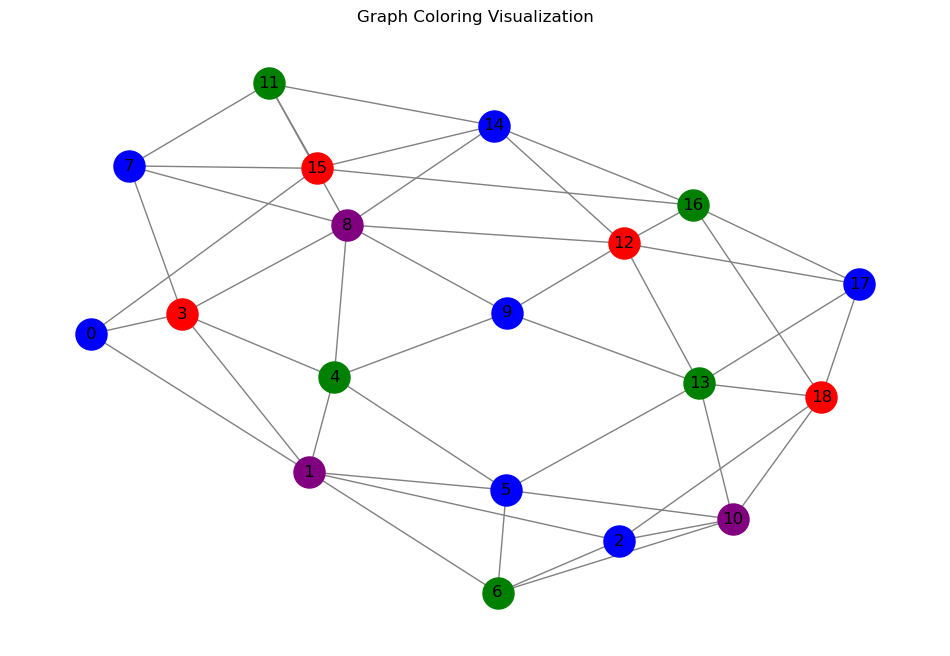

In [64]:
# After running the algorithm and getting the best solution
dict_probs = calculate_probabilities(result, GRAPH)
best_solution = result[dict_probs['fitness'].index(max(dict_probs['fitness']))]
visualize_graph(best_solution, GRAPH)

## Conclusion and Applications

In this implementation, we successfully solved the Graph Coloring Problem using a genetic algorithm approach. Our algorithm consistently found valid solutions using 4 colors, which is a reasonable result for the given graph structure. While these solutions are feasible and practical, it's worth noting that a solution with 3 colors might still be possible; which highlights a classic trade-off in heuristic methods between finding good solutions quickly versus finding optimal solutions.

### Performance Analysis
Our genetic algorithm demonstrated several strengths:
1. Quick convergence to valid solutions
2. Consistent ability to find 4-color solutions
3. Reasonable computational time
4. Multiple feasible solutions provided

### Alternative Approaches
While our genetic algorithm implementation worked well, other heuristic methods could also solve the GCP:
- Greedy algorithms (like Welsh-Powell)
- Simulated annealing
- Tabu search
- Ant colony optimization

Each method has its own trade-offs between solution quality, computation time, and implementation complexity. The genetic algorithm approach proved to be a good choice for our case, providing valid colorings within reasonable time frames, though it doesn't guarantee finding the minimum possible number of colors.

### Real-world Applications
The success of this implementation suggests its potential use in various practical scenarios:
- Scheduling problems (class timetabling, exam scheduling)
- Resource allocation in project management
- Frequency assignment in telecommunications
- Register allocation in compiler design

Finally, while our implementation successfully solved the problem with 4 colors, the nature of genetic algorithms means that different runs might yield different solutions.